In [2]:

# Uncomment to install psutil if needed (requires internet access)
!pip install psutil

import os
import zipfile
import glob
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, RocCurveDisplay
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
try:
    import psutil
    PSUTIL_AVAILABLE = True
except ImportError:
    PSUTIL_AVAILABLE = False

# System status function
def show_system_status():
    if PSUTIL_AVAILABLE:
        print(f"CPU Usage: {psutil.cpu_percent()}%")
    else:
        print("CPU Usage: Not available (psutil not installed)")
    if torch.cuda.is_available():
        gpu_mem = torch.cuda.mem_get_info()
        print(f"GPU: {torch.cuda.get_device_name(0)}")
        print(f"GPU Free Memory: {gpu_mem[0] / (1024 ** 3):.2f} GB / {gpu_mem[1] / (1024 ** 3):.2f} GB")
    else:
        print("No GPU detected.")

# Kaggle-specific paths
INPUT_PATH = "/kaggle/input/fnd-dataset-ani"  # Replace with your dataset name
WORK_PATH = "/kaggle/working"

# Display initial system status
show_system_status()


CPU Usage: 13.3%
GPU: Tesla P100-PCIE-16GB
GPU Free Memory: 15.64 GB / 15.89 GB


In [3]:

# Define paths to the extracted embedding folders
image_embedding_folders = [
    os.path.join(INPUT_PATH, f, 'image_embeddings_merged') for f in [
        "image_embeddings_merged-20250613T064153Z-1-001",
        "image_embeddings_merged-20250613T064153Z-1-002",
        "image_embeddings_merged-20250613T064153Z-1-003",
        "image_embeddings_merged-20250613T064153Z-1-004"
    ]
]

text_embedding_folders = [
    os.path.join(INPUT_PATH, f, 'title_embeddings') for f in [
        "title_embeddings-20250613T064214Z-1-001",
        "title_embeddings-20250613T064214Z-1-002",
        "title_embeddings-20250613T064214Z-1-003"
    ]
]

def check_extracted_folders(folder_list, folder_type):
    for folder in folder_list:
        if os.path.exists(folder):
            file_count = len(glob.glob(os.path.join(folder, '*.npy')))
            print(f"✅ Found {folder_type} folder: {folder} with {file_count} .npy files")
        else:
            print(f"⚠ {folder_type} folder not found: {folder}")

show_system_status()
print("Checking image embedding folders:")
check_extracted_folders(image_embedding_folders, "Image embeddings")
print("\nChecking text embedding folders:")
check_extracted_folders(text_embedding_folders, "Text embeddings")


CPU Usage: 1.3%
GPU: Tesla P100-PCIE-16GB
GPU Free Memory: 15.64 GB / 15.89 GB
Checking image embedding folders:
✅ Found Image embeddings folder: /kaggle/input/fnd-dataset-ani/image_embeddings_merged-20250613T064153Z-1-001/image_embeddings_merged with 65535 .npy files
✅ Found Image embeddings folder: /kaggle/input/fnd-dataset-ani/image_embeddings_merged-20250613T064153Z-1-002/image_embeddings_merged with 65535 .npy files
✅ Found Image embeddings folder: /kaggle/input/fnd-dataset-ani/image_embeddings_merged-20250613T064153Z-1-003/image_embeddings_merged with 65535 .npy files
✅ Found Image embeddings folder: /kaggle/input/fnd-dataset-ani/image_embeddings_merged-20250613T064153Z-1-004/image_embeddings_merged with 57690 .npy files

Checking text embedding folders:
✅ Found Text embeddings folder: /kaggle/input/fnd-dataset-ani/title_embeddings-20250613T064214Z-1-001/title_embeddings with 65535 .npy files
✅ Found Text embeddings folder: /kaggle/input/fnd-dataset-ani/title_embeddings-20250613T

In [6]:

show_system_status()

image_files = {}
for img_root in glob.glob(os.path.join(INPUT_PATH, 'image_embeddings_merged-20250613T064153Z-1-00*/image_embeddings_merged')):
    for file_path in glob.glob(os.path.join(img_root, '*.npy')):
        file_id = os.path.splitext(os.path.basename(file_path))[0]
        image_files[file_id] = file_path

text_files = {}
for txt_root in glob.glob(os.path.join(INPUT_PATH, 'title_embeddings-20250613T064214Z-1-00*/title_embeddings')):
    for file_path in glob.glob(os.path.join(txt_root, '*.npy')):
        file_id = os.path.basename(file_path).replace('_title_embedding.npy', '')
        text_files[file_id] = file_path

print(f"✅ Found {len(image_files)} image embeddings")
print(f"✅ Found {len(text_files)} text embeddings")

df_labels = pd.read_csv(os.path.join(INPUT_PATH, "multimodal_train.tsv"), sep='\t', usecols=["id", "2_way_label"])
valid_ids = set(df_labels['id']) & set(image_files.keys()) & set(text_files.keys())
df_valid = df_labels[df_labels['id'].isin(valid_ids)].reset_index(drop=True)

records = []
for _, row in tqdm(df_valid.iterrows(), total=len(df_valid)):
    id_ = row['id']
    records.append({
        'id': id_,
        'label': row['2_way_label'],
        'image_path': image_files[id_],
        'text_path': text_files[id_]
    })

final_df = pd.DataFrame(records)
final_df.to_parquet(os.path.join(WORK_PATH, "final_data.parquet"))
print(f"✅ Final matched records: {len(final_df)}")
print(final_df['label'].value_counts())


CPU Usage: 7.4%
GPU: Tesla P100-PCIE-16GB
GPU Free Memory: 15.64 GB / 15.89 GB
✅ Found 254295 image embeddings
✅ Found 143381 text embeddings


100%|██████████| 81475/81475 [00:03<00:00, 26354.48it/s]


✅ Final matched records: 81475
label
1    45053
0    36422
Name: count, dtype: int64


In [8]:

class MultiModalDataset(Dataset):
    def __init__(self, dataframe):
        self.df = dataframe

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        try:
            image = np.load(row['image_path'])
            text = np.load(row['text_path'])
        except Exception as e:
            print(f"⚠ Skipping {row['id']} due to load error: {e}")
            dummy_feat = np.zeros(768 + 384, dtype=np.float32)
            dummy_label = np.float32(0)
            return torch.tensor(dummy_feat), torch.tensor(dummy_label)
        features = np.concatenate([image, text]).astype(np.float32)
        label = np.float32(row['label'])
        return torch.tensor(features), torch.tensor(label)

portion = 1
df_sampled = final_df.groupby('label').apply(lambda x: x.sample(frac=portion, random_state=42)).reset_index(drop=True)

X_train, X_test = train_test_split(df_sampled, test_size=0.2, stratify=df_sampled['label'], random_state=42)

train_ds = MultiModalDataset(X_train)
test_ds = MultiModalDataset(X_test)

batch_size = 64 # Reduced for Kaggle GPU memory constraints
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

print(f"✅ Train size: {len(train_ds)}, Test size: {len(test_ds)}")


✅ Train size: 65173, Test size: 16294


/tmp/ipykernel_152/2803016237.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = final_df.groupby('label').apply(lambda x: x.sample(frac=portion, random_state=42)).reset_index(drop=True)


In [7]:


valid_records = []
corrupted = ['87cou5', '20pfxo']
for idx, row in tqdm(final_df.iterrows(), total=len(final_df), desc="Validating data"):
    if row['id'] in corrupted:
        continue
    try:
        img = np.load(row['image_path'])
        txt = np.load(row['text_path'])
        if not (np.isfinite(img).all() and np.isfinite(txt).all()):
            print(f"⚠ Skipping {row['id']} due to NaN or Inf values")   
            continue
        if img.shape != (768,) or txt.shape != (384,):
            print(f"⚠ Skipping {row['id']} due to shape mismatch: img {img.shape}, txt {txt.shape}")
            continue
        valid_records.append(row)
    except Exception as e:
        print(f"⚠ Skipping {row['id']} due to load error: {e}")
        continue

final_df = pd.DataFrame(valid_records)
final_df.to_parquet(os.path.join(WORK_PATH, "final_valid_data.parquet"))
print(f"✅ Valid records: {len(final_df)}")
print(final_df['label'].value_counts())



Validating data:  51%|█████     | 41279/81475 [02:12<01:11, 562.06it/s]

⚠ Skipping bk2wdt due to load error: No data left in file
⚠ Skipping 6tswke due to load error: No data left in file
⚠ Skipping b3bvbr due to load error: No data left in file
⚠ Skipping bnswqp due to load error: No data left in file
⚠ Skipping 6gt0rc due to load error: No data left in file
⚠ Skipping 83f5ua due to load error: No data left in file


Validating data: 100%|██████████| 81475/81475 [03:22<00:00, 403.19it/s]


✅ Valid records: 81467
label
1    45047
0    36420
Name: count, dtype: int64


In [ ]:
'''
class CoAttention(nn.Module):
    def __init__(self, embed_dim, heads=4):
        super().__init__()
        self.query_img = nn.Linear(embed_dim, embed_dim)
        self.key_text = nn.Linear(embed_dim, embed_dim)
        self.value_text = nn.Linear(embed_dim, embed_dim)
        self.query_text = nn.Linear(embed_dim, embed_dim)
        self.key_img = nn.Linear(embed_dim, embed_dim)
        self.value_img = nn.Linear(embed_dim, embed_dim)
        self.attn_heads = heads
        self.scale = (embed_dim // heads) ** -0.5
        self.norm_img = nn.LayerNorm(embed_dim)
        self.norm_text = nn.LayerNorm(embed_dim)

    def forward(self, img_emb, text_emb):
        batch_size = img_emb.size(0)
        
        # Image attends to text
        q_img = self.query_img(img_emb).view(batch_size, self.attn_heads, -1)
        k_text = self.key_text(text_emb).view(batch_size, self.attn_heads, -1)
        v_text = self.value_text(text_emb).view(batch_size, self.attn_heads, -1)
        attn_img = torch.softmax((q_img @ k_text.transpose(-2, -1)) * self.scale, dim=-1)
        img_out = (attn_img @ v_text).view(batch_size, -1)
        
        # Text attends to image
        q_text = self.query_text(text_emb).view(batch_size, self.attn_heads, -1)
        k_img = self.key_img(img_emb).view(batch_size, self.attn_heads, -1)
        v_img = self.value_img(img_emb).view(batch_size, self.attn_heads, -1)
        attn_text = torch.softmax((q_text @ k_img.transpose(-2, -1)) * self.scale, dim=-1)
        text_out = (attn_text @ v_img).view(batch_size, -1)
        
        return self.norm_img(img_out), self.norm_text(text_out)

class CrossModalTransformer(nn.Module):
    def __init__(self, embed_dim, heads=4, ff_dim=512, dropout=0.1):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim, heads, dropout=dropout, batch_first=True)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.ff = nn.Sequential(
            nn.Linear(embed_dim, ff_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(ff_dim, embed_dim)
        )
        self.norm2 = nn.LayerNorm(embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        attn_out, _ = self.attn(x, x, x)
        x = self.norm1(x + self.dropout(attn_out))
        ff_out = self.ff(x)
        x = self.norm2(x + self.dropout(ff_out))
        return x

class CrossFusionMFN(nn.Module):
    def __init__(self, img_dim=768, text_dim=384, internal_dim=256, num_layers=3, heads=4, dropout=0.2):
        super().__init__()
        self.img_dim = img_dim
        self.text_dim = text_dim
        embed_dim = img_dim + text_dim
        
        # Co-attention
        self.co_attn = CoAttention(img_dim, heads=heads)
        
        # Cross-modal transformers
        self.transformer = nn.ModuleList([
            CrossModalTransformer(img_dim, heads=heads, ff_dim=internal_dim*2, dropout=dropout)
            for _ in range(2)
        ])
        
        # Fusion strategies
        self.concat_linear = nn.Linear(img_dim * 2, internal_dim)
        self.bilinear_w = nn.Parameter(torch.randn(img_dim, img_dim, internal_dim))
        
        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(internal_dim, internal_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.LayerNorm(internal_dim),
            nn.Linear(internal_dim, internal_dim // 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.LayerNorm(internal_dim // 2),
            nn.Linear(internal_dim // 2, internal_dim // 4),    
            nn.GELU(),
            nn.Dropout(dropout),
            nn.LayerNorm(internal_dim // 4),
            nn.Linear(internal_dim // 4, 1)
        )

    def bilinear_pooling(self, x1, x2):
        batch_size = x1.size(0)
        x1 = x1.unsqueeze(-1)
        x2 = x2.unsqueeze(-2)
        out = torch.matmul(torch.matmul(x1, x2), self.bilinear_w.view(self.img_dim, -1))
        return out.view(batch_size, -1)

    def forward(self, x):
        img_emb = x[:, :self.img_dim]
        text_emb = x[:, self.img_dim:]
        
        # Co-attention
        img_out, text_out = self.co_attn(img_emb, text_emb)
        
        # Cross-modal transformers
        combined = torch.stack([img_out, text_out], dim=1)  # (batch_size, 2, embed_dim)
        for layer in self.transformer:
            combined = layer(combined)
        
        img_out, text_out = combined[:, 0], combined[:, 1]
        
        # Fusion strategies
        concat_fusion = self.concat_linear(torch.cat([img_out, text_out], dim=-1))
        bilinear_fusion = self.bilinear_pooling(img_out, text_out)
        
        # Combine fusions
        fused = concat_fusion + bilinear_fusion
        
        # Classifier
        return self.classifier(fused).squeeze()
'''

In [ ]:
'''
class CoAttention(nn.Module):
    def __init__(self, img_dim=768, text_dim=384, heads=4):
        super().__init__()
        self.query_img = nn.Linear(img_dim, img_dim)
        self.key_text = nn.Linear(text_dim, img_dim)  # Project text to image dim
        self.value_text = nn.Linear(text_dim, img_dim)  # Project text to image dim
        self.query_text = nn.Linear(text_dim, img_dim)  # Project text to image dim
        self.key_img = nn.Linear(img_dim, img_dim)
        self.value_img = nn.Linear(img_dim, img_dim)
        self.attn_heads = heads
        self.scale = (img_dim // heads) ** -0.5
        self.norm_img = nn.LayerNorm(img_dim)
        self.norm_text = nn.LayerNorm(img_dim)

    def forward(self, img_emb, text_emb):
        batch_size = img_emb.size(0)
        
        # Image attends to text
        q_img = self.query_img(img_emb).view(batch_size, self.attn_heads, -1)
        k_text = self.key_text(text_emb).view(batch_size, self.attn_heads, -1)
        v_text = self.value_text(text_emb).view(batch_size, self.attn_heads, -1)
        attn_img = torch.softmax((q_img @ k_text.transpose(-2, -1)) * self.scale, dim=-1)
        img_out = (attn_img @ v_text).view(batch_size, -1)
        
        # Text attends to image
        q_text = self.query_text(text_emb).view(batch_size, self.attn_heads, -1)
        k_img = self.key_img(img_emb).view(batch_size, self.attn_heads, -1)
        v_img = self.value_img(img_emb).view(batch_size, self.attn_heads, -1)
        attn_text = torch.softmax((q_text @ k_img.transpose(-2, -1)) * self.scale, dim=-1)
        text_out = (attn_text @ v_img).view(batch_size, -1)
        
        return self.norm_img(img_out), self.norm_text(text_out)

class CrossModalTransformer(nn.Module):
    def __init__(self, embed_dim, heads=4, ff_dim=512, dropout=0.1):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim, heads, dropout=dropout, batch_first=True)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.ff = nn.Sequential(
            nn.Linear(embed_dim, ff_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(ff_dim, embed_dim)
        )
        self.norm2 = nn.LayerNorm(embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        attn_out, _ = self.attn(x, x, x)
        x = self.norm1(x + self.dropout(attn_out))
        ff_out = self.ff(x)
        x = self.norm2(x + self.dropout(ff_out))
        return x

class CrossFusionMFN(nn.Module):
    def __init__(self, img_dim=768, text_dim=384, internal_dim=256, num_layers=3, heads=4, dropout=0.2):
        super().__init__()
        self.img_dim = img_dim
        self.text_dim = text_dim
        embed_dim = img_dim + text_dim
        
        # Co-attention
        self.co_attn = CoAttention(img_dim=img_dim, text_dim=text_dim, heads=heads)
        
        # Cross-modal transformers
        self.transformer = nn.ModuleList([
            CrossModalTransformer(img_dim, heads=heads, ff_dim=internal_dim*2, dropout=dropout)
            for _ in range(2)
        ])
        
        # Fusion strategies
        self.concat_linear = nn.Linear(img_dim * 2, internal_dim)
        self.bilinear_w = nn.Parameter(torch.randn(img_dim, img_dim, internal_dim))
        
        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(internal_dim, internal_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.LayerNorm(internal_dim),
            nn.Linear(internal_dim, internal_dim // 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.LayerNorm(internal_dim // 2),
            nn.Linear(internal_dim // 2, internal_dim // 4),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.LayerNorm(internal_dim // 4),
            nn.Linear(internal_dim // 4, 1)
        )

    def bilinear_pooling(self, x1, x2):
        batch_size = x1.size(0)
        x1 = x1.unsqueeze(-1)
        x2 = x2.unsqueeze(-2)
        out = torch.matmul(torch.matmul(x1, x2), self.bilinear_w.view(self.img_dim, -1))
        return out.view(batch_size, -1)

    def forward(self, x):
        img_emb = x[:, :self.img_dim]
        text_emb = x[:, self.img_dim:]
        
        # Co-attention
        img_out, text_out = self.co_attn(img_emb, text_emb)
        
        # Cross-modal transformers
        combined = torch.stack([img_out, text_out], dim=1)  # (batch_size, 2, img_dim)
        for layer in self.transformer:
            combined = layer(combined)
        
        img_out, text_out = combined[:, 0], combined[:, 1]
        
        # Fusion strategies
        concat_fusion = self.concat_linear(torch.cat([img_out, text_out], dim=-1))
        bilinear_fusion = self.bilinear_pooling(img_out, text_out)
        
        # Combine fusions
        fused = concat_fusion + bilinear_fusion
        
        # Classifier
        return self.classifier(fused).squeeze()
'''

In [ ]:
'''
class CoAttention(nn.Module):
    def __init__(self, img_dim=768, text_dim=384, heads=4):
        super().__init__()
        self.query_img = nn.Linear(img_dim, img_dim)
        self.key_text = nn.Linear(text_dim, img_dim)  # Project text to image dim
        self.value_text = nn.Linear(text_dim, img_dim)  # Project text to image dim
        self.query_text = nn.Linear(text_dim, img_dim)  # Project text to image dim
        self.key_img = nn.Linear(img_dim, img_dim)
        self.value_img = nn.Linear(img_dim, img_dim)
        self.attn_heads = heads
        self.scale = (img_dim // heads) ** -0.5
        self.norm_img = nn.LayerNorm(img_dim)
        self.norm_text = nn.LayerNorm(img_dim)

    def forward(self, img_emb, text_emb):
        batch_size = img_emb.size(0)
        
        # Image attends to text
        q_img = self.query_img(img_emb).view(batch_size, self.attn_heads, -1)
        k_text = self.key_text(text_emb).view(batch_size, self.attn_heads, -1)
        v_text = self.value_text(text_emb).view(batch_size, self.attn_heads, -1)
        attn_img = torch.softmax((q_img @ k_text.transpose(-2, -1)) * self.scale, dim=-1)
        img_out = (attn_img @ v_text).view(batch_size, -1)
        
        # Text attends to image
        q_text = self.query_text(text_emb).view(batch_size, self.attn_heads, -1)
        k_img = self.key_img(img_emb).view(batch_size, self.attn_heads, -1)
        v_img = self.value_img(img_emb).view(batch_size, self.attn_heads, -1)
        attn_text = torch.softmax((q_text @ k_img.transpose(-2, -1)) * self.scale, dim=-1)
        text_out = (attn_text @ v_img).view(batch_size, -1)
        
        return self.norm_img(img_out), self.norm_text(text_out)

class CrossModalTransformer(nn.Module):
    def __init__(self, embed_dim, heads=4, ff_dim=512, dropout=0.1):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim, heads, dropout=dropout, batch_first=True)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.ff = nn.Sequential(
            nn.Linear(embed_dim, ff_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(ff_dim, embed_dim)
        )
        self.norm2 = nn.LayerNorm(embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        attn_out, _ = self.attn(x, x, x)
        x = self.norm1(x + self.dropout(attn_out))
        ff_out = self.ff(x)
        x = self.norm2(x + self.dropout(ff_out))
        return x

class CrossFusionMFN(nn.Module):
    def __init__(self, img_dim=768, text_dim=384, internal_dim=256, num_layers=3, heads=4, dropout=0.2):
        super().__init__()
        self.img_dim = img_dim
        self.text_dim = text_dim
        embed_dim = img_dim + text_dim
        
        # Co-attention
        self.co_attn = CoAttention(img_dim=img_dim, text_dim=text_dim, heads=heads)
        
        # Cross-modal transformers
        self.transformer = nn.ModuleList([
            CrossModalTransformer(img_dim, heads=heads, ff_dim=internal_dim*2, dropout=dropout)
            for _ in range(2)
        ])
        
        # Fusion strategies
        self.concat_linear = nn.Linear(img_dim * 2, internal_dim)
        self.bilinear_proj1 = nn.Linear(img_dim, 64)  # Low-rank projection for x1
        self.bilinear_proj2 = nn.Linear(img_dim, 64)  # Low-rank projection for x2
        self.bilinear_out = nn.Linear(64 * 64, internal_dim)  # Output projection
        
        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(internal_dim, internal_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.LayerNorm(internal_dim),
            nn.Linear(internal_dim, internal_dim // 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.LayerNorm(internal_dim // 2),
            nn.Linear(internal_dim // 2, internal_dim // 4),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.LayerNorm(internal_dim // 4),
            nn.Linear(internal_dim // 4, 1)
        )

    def bilinear_pooling(self, x1, x2):
        batch_size = x1.size(0)
        # Low-rank projections
        x1 = self.bilinear_proj1(x1)  # (batch_size, 64)
        x2 = self.bilinear_proj2(x2)  # (batch_size, 64)
        # Outer product
        outer = x1.unsqueeze(-1) * x2.unsqueeze(-2)  # (batch_size, 64, 64)
        # Flatten and project
        out = self.bilinear_out(outer.view(batch_size, -1))  # (batch_size, internal_dim)
        return out

    def forward(self, x):
        img_emb = x[:, :self.img_dim]
        text_emb = x[:, self.img_dim:]
        
        # Co-attention
        img_out, text_out = self.co_attn(img_emb, text_emb)
        
        # Cross-modal transformers
        combined = torch.stack([img_out, text_out], dim=1)  # (batch_size, 2, img_dim)
        for layer in self.transformer:
            combined = layer(combined)
        
        img_out, text_out = combined[:, 0], combined[:, 1]
        
        # Fusion strategies
        concat_fusion = self.concat_linear(torch.cat([img_out, text_out], dim=-1))
        bilinear_fusion = self.bilinear_pooling(img_out, text_out)
        
        # Combine fusions
        fused = concat_fusion + bilinear_fusion
        
        # Classifier
        return self.classifier(fused).squeeze()
'''

In [ ]:
'''
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

def train_model(model, train_loader, test_loader, epochs=10, label_smoothing=0.1):
    show_system_status()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scaler = torch.amp.GradScaler('cuda')
    
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_count = 0
        
        for features, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            features, labels = features.to(device), labels.to(device)
            if features.sum() == 0:  # Skip dummy data
                continue
            
            # Manual label smoothing
            labels_smooth = labels * (1 - label_smoothing) + (1 - labels) * label_smoothing
            
            optimizer.zero_grad()
            with torch.amp.autocast('cuda'):
                outputs = model(features)
                loss = criterion(outputs, labels_smooth)
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            train_loss += loss.item() * labels.size(0)
            train_count += labels.size(0)
        
        train_loss /= train_count
        train_losses.append(train_loss)
        
        model.eval()
        val_loss = 0
        val_count = 0
        trues, preds = [], []
        
        with torch.no_grad():
            for features, labels in test_loader:
                features, labels = features.to(device), labels.to(device)
                if features.sum() == 0:
                    continue
                
                # Manual label smoothing for validation
                labels_smooth = labels * (1 - label_smoothing) + (1 - labels) * label_smoothing
                
                with torch.amp.autocast('cuda'):
                    outputs = model(features)
                    loss = criterion(outputs, labels_smooth)
                
                val_loss += loss.item() * labels.size(0)
                val_count += labels.size(0)
                
                probs = torch.sigmoid(outputs).cpu().numpy()
                trues.extend(labels.cpu().numpy())
                preds.extend(probs)
        
        val_loss /= val_count
        val_losses.append(val_loss)
        
        print(f"Epoch {epoch+1} Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    
    # Evaluation
    trues = np.array(trues)
    preds = np.array(preds)
    
    plt.figure()
    RocCurveDisplay.from_predictions(trues, preds)
    plt.title("ROC Curve")
    plt.show()
    
    roc_auc = roc_auc_score(trues, preds)
    print(f"ROC AUC: {roc_auc:.4f}")
    
    pred_labels = (preds > 0.5).astype(int)
    print(classification_report(trues, pred_labels))
    
    cm = confusion_matrix(trues, pred_labels)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.show()
    
    plt.figure()
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.legend()
    plt.title("Loss Curve")
    plt.show()
    
    return model, trues, preds

show_system_status()
model = CrossFusionMFN(img_dim=768, text_dim=384)
model, trues, preds = train_model(model, train_loader, test_loader)
'''

In [ ]:
'''
class CoAttention(nn.Module):
    def __init__(self, img_dim=768, text_dim=384, heads=4):
        super().__init__()
        self.query_img = nn.Linear(img_dim, img_dim)
        self.key_text = nn.Linear(text_dim, img_dim)
        self.value_text = nn.Linear(text_dim, img_dim)
        self.query_text = nn.Linear(text_dim, img_dim)
        self.key_img = nn.Linear(img_dim, img_dim)
        self.value_img = nn.Linear(img_dim, img_dim)
        self.attn_heads = heads
        self.scale = (img_dim // heads) ** -0.5
        self.norm_img = nn.LayerNorm(img_dim)
        self.norm_text = nn.LayerNorm(img_dim)

    def forward(self, img_emb, text_emb):
        batch_size = img_emb.size(0)
        
        # Image attends to text
        q_img = self.query_img(img_emb).view(batch_size, self.attn_heads, -1)
        k_text = self.key_text(text_emb).view(batch_size, self.attn_heads, -1)
        v_text = self.value_text(text_emb).view(batch_size, self.attn_heads, -1)
        scores_img = (q_img @ k_text.transpose(-2, -1)) * self.scale
        scores_img = torch.clamp(scores_img, min=-10, max=10)  # Clip scores
        attn_img = torch.softmax(scores_img, dim=-1)
        img_out = (attn_img @ v_text).view(batch_size, -1)
        
        # Text attends to image
        q_text = self.query_text(text_emb).view(batch_size, self.attn_heads, -1)
        k_img = self.key_img(img_emb).view(batch_size, self.attn_heads, -1)
        v_img = self.value_img(img_emb).view(batch_size, self.attn_heads, -1)
        scores_text = (q_text @ k_img.transpose(-2, -1)) * self.scale
        scores_text = torch.clamp(scores_text, min=-10, max=10)  # Clip scores
        attn_text = torch.softmax(scores_text, dim=-1)
        text_out = (attn_text @ v_img).view(batch_size, -1)
        
        return self.norm_img(img_out), self.norm_text(text_out)

class CrossModalTransformer(nn.Module):
    def __init__(self, embed_dim, heads=4, ff_dim=512, dropout=0.1):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim, heads, dropout=dropout, batch_first=True)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.ff = nn.Sequential(
            nn.Linear(embed_dim, ff_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(ff_dim, embed_dim)
        )
        self.norm2 = nn.LayerNorm(embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        attn_out, _ = self.attn(x, x, x)
        x = self.norm1(x + self.dropout(attn_out))
        ff_out = self.ff(x)
        x = self.norm2(x + self.dropout(ff_out))
        return x

class CrossFusionMFN(nn.Module):
    def __init__(self, img_dim=768, text_dim=384, internal_dim=256, num_layers=3, heads=4, dropout=0.2):
        super().__init__()
        self.img_dim = img_dim
        self.text_dim = text_dim
        embed_dim = img_dim + text_dim
        
        # Co-attention
        self.co_attn = CoAttention(img_dim=img_dim, text_dim=text_dim, heads=heads)
        
        # Cross-modal transformers
        self.transformer = nn.ModuleList([
            CrossModalTransformer(img_dim, heads=heads, ff_dim=internal_dim*2, dropout=dropout)
            for _ in range(2)
        ])
        
        # Fusion strategies
        self.concat_linear = nn.Linear(img_dim * 2, internal_dim)
        self.bilinear_proj1 = nn.Linear(img_dim, 64)
        self.bilinear_proj2 = nn.Linear(img_dim, 64)
        self.bilinear_out = nn.Linear(64 * 64, internal_dim)
        
        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(internal_dim, internal_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.LayerNorm(internal_dim),
            nn.Linear(internal_dim, internal_dim // 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.LayerNorm(internal_dim // 2),
            nn.Linear(internal_dim // 2, internal_dim // 4),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.LayerNorm(internal_dim // 4),
            nn.Linear(internal_dim // 4, 1)
        )

    def bilinear_pooling(self, x1, x2):
        batch_size = x1.size(0)
        x1 = self.bilinear_proj1(x1)
        x2 = self.bilinear_proj2(x2)
        outer = x1.unsqueeze(-1) * x2.unsqueeze(-2)
        out = self.bilinear_out(outer.view(batch_size, -1))
        return out

    def forward(self, x):
        img_emb = x[:, :self.img_dim]
        text_emb = x[:, self.img_dim:]
        
        # Co-attention
        img_out, text_out = self.co_attn(img_emb, text_emb)
        
        # Cross-modal transformers
        combined = torch.stack([img_out, text_out], dim=1)
        for layer in self.transformer:
            combined = layer(combined)
        
        img_out, text_out = combined[:, 0], combined[:, 1]
        
        # Fusion strategies
        concat_fusion = self.concat_linear(torch.cat([img_out, text_out], dim=-1))
        bilinear_fusion = self.bilinear_pooling(img_out, text_out)
        
        # Combine fusions
        fused = concat_fusion + bilinear_fusion
        
        # Classifier
        return self.classifier(fused).squeeze()
'''

In [ ]:

'''import torch
import torch.nn as nn
import torch.nn.functional as F

class CrossFusionMFN(nn.Module):
    def __init__(self, img_dim=768, text_dim=384, hidden_dim=256, dropout_rate=0.4, rank=32):
        super(CrossFusionMFN, self).__init__()
        
        # Image branch
        self.img_fc1 = nn.Linear(img_dim, hidden_dim)
        self.img_fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.img_fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.img_dropout1 = nn.Dropout(dropout_rate)
        self.img_dropout2 = nn.Dropout(dropout_rate)
        self.img_dropout3 = nn.Dropout(dropout_rate)
        
        # Text branch
        self.text_fc1 = nn.Linear(text_dim, hidden_dim)
        self.text_fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.text_fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.text_dropout1 = nn.Dropout(dropout_rate)
        self.text_dropout2 = nn.Dropout(dropout_rate)
        self.text_dropout3 = nn.Dropout(dropout_rate)
        
        # Low-rank bilinear pooling
        self.U = nn.Parameter(torch.randn(rank, hidden_dim))
        self.V = nn.Parameter(torch.randn(rank, hidden_dim))
        self.W = nn.Parameter(torch.randn(rank, 1))  # Changed from (1, rank) to (rank, 1)
        
        # Output layer
        self.fc_out = nn.Linear(hidden_dim, 1)
        self.dropout_out = nn.Dropout(dropout_rate)
        
    def forward(self, x):
        img, text = x[:, :768], x[:, 768:]  # Assuming concatenated [img, text]
        
        # Image branch
        img = F.relu(self.img_fc1(img))
        img = self.img_dropout1(img)
        img = F.relu(self.img_fc2(img))
        img = self.img_dropout2(img)
        img = F.relu(self.img_fc3(img))
        img = self.img_dropout3(img)
        
        # Text branch
        text = F.relu(self.text_fc1(text))
        text = self.text_dropout1(text)
        text = F.relu(self.text_fc2(text))
        text = self.text_dropout2(text)
        text = F.relu(self.text_fc3(text))
        text = self.text_dropout3(text)
        
        # Stabilized attention with low-rank bilinear pooling
        batch_size = img.size(0)
        attention = torch.matmul(img, self.U.t()) * torch.matmul(text, self.V.t())
        attention = F.softmax(attention.clamp(-10, 10), dim=-1)  # Clamp to prevent nan
        fused = torch.matmul(attention, self.W).squeeze(-1)
        
        # Combine branches
        combined = img * text * fused
        out = self.fc_out(self.dropout_out(combined))
        return out

# Initialize model
img_dim = 768
text_dim = 384
model = CrossFusionMFN(img_dim=img_dim, text_dim=text_dim)
'''

In [ ]:
'''import torch
import torch.nn as nn
import torch.nn.functional as F

class CLIPStyleModel(nn.Module):
    def __init__(self, img_dim=768, text_dim=384, embed_dim=512):
        super().__init__()
        # Projection layers
        self.img_proj = nn.Linear(img_dim, embed_dim)
        self.text_proj = nn.Linear(text_dim, embed_dim)

        # Classifier head
        self.fc1 = nn.Linear(embed_dim * 2, 256)
        self.dropout = nn.Dropout(0.3)
        self.fc_out = nn.Linear(256, 1)

    def forward(self, x):
        img = x[:, :768]
        text = x[:, 768:]

        img_emb = F.normalize(self.img_proj(img), dim=-1)
        text_emb = F.normalize(self.text_proj(text), dim=-1)

        # Joint embedding: concat or similarity + feed to classifier
        joint = torch.cat([img_emb, text_emb], dim=-1)

        x = F.relu(self.fc1(joint))
        x = self.dropout(x)
        out = self.fc_out(x)
        return out'''


In [ ]:
'''import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

def train_model(model, train_loader, test_loader, epochs=10, label_smoothing=0.1):
    show_system_status()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)
    scaler = torch.amp.GradScaler('cuda')
    
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_count = 0
        
        for features, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            features, labels = features.to(device), labels.to(device)
            if features.sum() == 0:  # Skip dummy data
                continue
            
            # Manual label smoothing
            labels_smooth = labels * (1 - label_smoothing) + (1 - labels) * label_smoothing
            
            optimizer.zero_grad()
            with torch.amp.autocast('cuda'):
                outputs = model(features)
                loss = criterion(outputs, labels_smooth)
            
            if torch.isnan(loss) or torch.isinf(loss):
                print(f"⚠ Skipping batch due to NaN/Inf loss")
                continue
            
            scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()
            
            train_loss += loss.item() * labels.size(0)
            train_count += labels.size(0)
        
        train_loss = train_loss / train_count if train_count > 0 else float('nan')
        train_losses.append(train_loss)
        
        model.eval()
        val_loss = 0
        val_count = 0
        trues, preds = [], []
        
        with torch.no_grad():
            for features, labels in test_loader:
                features, labels = features.to(device), labels.to(device)
                if features.sum() == 0:
                    continue
                
                labels_smooth = labels * (1 - label_smoothing) + (1 - labels) * label_smoothing
                
                with torch.amp.autocast('cuda'):
                    outputs = model(features)
                    loss = criterion(outputs, labels_smooth)
                
                if torch.isnan(loss) or torch.isinf(loss):
                    continue
                
                val_loss += loss.item() * labels.size(0)
                val_count += labels.size(0)
                
                probs = torch.sigmoid(outputs).cpu().numpy()
                trues.extend(labels.cpu().numpy())
                preds.extend(probs)
        
        val_loss = val_loss / val_count if val_count > 0 else float('nan')
        val_losses.append(val_loss)
        
        print(f"Epoch {epoch+1} Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    
    # Evaluation
    if not trues:
        print("⚠ No valid predictions for evaluation")
        return model, [], []
    
    trues = np.array(trues)
    preds = np.array(preds)
    
    plt.figure()
    RocCurveDisplay.from_predictions(trues, preds)
    plt.title("ROC Curve")
    plt.savefig(os.path.join(WORK_PATH, "roc_curve.png"))
    plt.show()
    
    roc_auc = roc_auc_score(trues, preds)
    print(f"ROC AUC: {roc_auc:.4f}")
    
    pred_labels = (preds > 0.5).astype(int)
    print(classification_report(trues, pred_labels))
    
    cm = confusion_matrix(trues, pred_labels)
    plt.figure()
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.savefig(os.path.join(WORK_PATH, "confusion_matrix.png"))
    plt.show()
    
    plt.figure()
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.legend()
    plt.title("Loss Curve")
    plt.savefig(os.path.join(WORK_PATH, "loss_curve.png"))
    plt.show()
    
    return model, trues, preds

show_system_status()
model = CLIPStyleModel()
train_model(model, train_loader, test_loader)
'''

In [9]:
class CoAttention(nn.Module):
    def __init__(self, embed_dim, heads=4):
        super().__init__()
        self.query_img = nn.Linear(embed_dim, embed_dim)
        self.key_text = nn.Linear(embed_dim, embed_dim)
        self.value_text = nn.Linear(embed_dim, embed_dim)
        self.query_text = nn.Linear(embed_dim, embed_dim)
        self.key_img = nn.Linear(embed_dim, embed_dim)
        self.value_img = nn.Linear(embed_dim, embed_dim)
        self.attn_heads = heads
        self.scale = (embed_dim // heads) ** -0.5
        self.norm_img = nn.LayerNorm(embed_dim)
        self.norm_text = nn.LayerNorm(embed_dim)

    def forward(self, img_emb, text_emb):
        batch_size = img_emb.size(0)
        
        # Image attends to text
        q_img = self.query_img(img_emb).view(batch_size, self.attn_heads, -1)
        k_text = self.key_text(text_emb).view(batch_size, self.attn_heads, -1)
        v_text = self.value_text(text_emb).view(batch_size, self.attn_heads, -1)
        attn_img = torch.softmax((q_img @ k_text.transpose(-2, -1)) * self.scale, dim=-1)
        img_out = (attn_img @ v_text).view(batch_size, -1)
        
        # Text attends to image
        q_text = self.query_text(text_emb).view(batch_size, self.attn_heads, -1)
        k_img = self.key_img(img_emb).view(batch_size, self.attn_heads, -1)
        v_img = self.value_img(img_emb).view(batch_size, self.attn_heads, -1)
        attn_text = torch.softmax((q_text @ k_img.transpose(-2, -1)) * self.scale, dim=-1)
        text_out = (attn_text @ v_img).view(batch_size, -1)
        
        return self.norm_img(img_out), self.norm_text(text_out)


class CFTransformerPlusPlus(nn.Module):
    def __init__(self, img_dim=768, text_dim=384, internal_dim=256, heads=4, dropout=0.2):
        super().__init__()
        self.img_dim = img_dim
        self.text_dim = text_dim
        self.embed_dim = img_dim  # Assuming both are projected to same dim

        # Project text to image embedding dimension
        self.text_proj = nn.Linear(text_dim, img_dim)

        # Co-attention transformer
        self.co_attn = CoAttention(img_dim, heads=heads)

        # Semantic alignment
        self.similarity_score = nn.CosineSimilarity(dim=-1)

        # Modality importance predictor
        self.importance_predictor = nn.Sequential(
            nn.Linear(img_dim * 2 + 1, internal_dim),
            nn.GELU(),
            nn.Linear(internal_dim, 2),
            nn.Softmax(dim=-1)
        )

        # Residual enhancement
        self.residual_fusion = nn.Linear(img_dim * 3, internal_dim)

        # Final classifier
        self.classifier = nn.Sequential(
            nn.Linear(internal_dim, internal_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.LayerNorm(internal_dim),
            nn.Linear(internal_dim, internal_dim // 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.LayerNorm(internal_dim // 2),
            nn.Linear(internal_dim // 2, 1)
        )

    def forward(self, x):
        img_emb = x[:, :self.img_dim]
        text_emb = x[:, self.img_dim:]
        text_emb = self.text_proj(text_emb)

        # Co-attention transformer
        img_out, text_out = self.co_attn(img_emb, text_emb)

        # Semantic alignment score
        sim_score = self.similarity_score(img_out, text_out).unsqueeze(-1)

        # Modality importance prediction
        fusion_input = torch.cat([img_out, text_out, sim_score], dim=-1)
        weights = self.importance_predictor(fusion_input)  # shape: (batch, 2)
        w_img, w_text = weights[:, 0].unsqueeze(-1), weights[:, 1].unsqueeze(-1)

        # Weighted fusion
        weighted_fusion = w_img * img_out + w_text * text_out

        # Residual enhancement
        residual_input = torch.cat([weighted_fusion, img_emb, text_emb], dim=-1)
        fused = self.residual_fusion(residual_input)

        # Classification
        return self.classifier(fused)


In [10]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

def train_model(model, train_loader, test_loader, epochs=10, label_smoothing=0.1):
    show_system_status()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)
    scaler = torch.amp.GradScaler('cuda')
    
    train_losses = []             
    val_losses = []
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_count = 0
        
        for features, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            features, labels = features.to(device), labels.to(device)
            if features.sum() == 0:
                continue
            
            labels_smooth = labels * (1 - label_smoothing) + (1 - labels) * label_smoothing
            labels_smooth = labels_smooth.unsqueeze(1)  # ✅ FIX: match output shape
            
            optimizer.zero_grad()
            with torch.amp.autocast('cuda'):
                outputs = model(features)
                loss = criterion(outputs, labels_smooth)
            
            if torch.isnan(loss) or torch.isinf(loss):
                print(f"⚠ Skipping batch due to NaN/Inf loss")
                continue
            
            scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()
            
            train_loss += loss.item() * labels.size(0)
            train_count += labels.size(0)
        
        train_loss = train_loss / train_count if train_count > 0 else float('nan')
        train_losses.append(train_loss)
        
        # ===== Validation =====
        model.eval()
        val_loss = 0
        val_count = 0
        trues, preds = [], []
        
        with torch.no_grad():
            for features, labels in test_loader:
                features, labels = features.to(device), labels.to(device)
                if features.sum() == 0:
                    continue
                
                labels_smooth = labels * (1 - label_smoothing) + (1 - labels) * label_smoothing
                labels_smooth = labels_smooth.unsqueeze(1)  # ✅ FIX: match output shape
                
                with torch.amp.autocast('cuda'):
                    outputs = model(features)
                    loss = criterion(outputs, labels_smooth)
                
                if torch.isnan(loss) or torch.isinf(loss):
                    continue
                
                val_loss += loss.item() * labels.size(0)
                val_count += labels.size(0)
                
                probs = torch.sigmoid(outputs).cpu().numpy()
                trues.extend(labels.cpu().numpy())
                preds.extend(probs)
        
        val_loss = val_loss / val_count if val_count > 0 else float('nan')
        val_losses.append(val_loss)
        
        print(f"Epoch {epoch+1} Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    
    # ===== Final eval =====
    if not trues:
        print("⚠ No valid predictions for evaluation")
        return model, [], []
    
    trues = np.array(trues)
    preds = np.array(preds)
    
    plt.figure()
    RocCurveDisplay.from_predictions(trues, preds)
    plt.title("ROC Curve")
    plt.savefig(os.path.join(WORK_PATH, "roc_curve.png"))
    plt.show()
    
    roc_auc = roc_auc_score(trues, preds)
    print(f"ROC AUC: {roc_auc:.4f}")
    
    pred_labels = (preds > 0.5).astype(int)
    print(classification_report(trues, pred_labels))
    
    cm = confusion_matrix(trues, pred_labels)
    plt.figure()
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.savefig(os.path.join(WORK_PATH, "confusion_matrix.png"))
    plt.show()
    
    plt.figure()
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.legend()
    plt.title("Loss Curve")
    plt.savefig(os.path.join(WORK_PATH, "loss_curve.png"))
    plt.show()
    
    return model, trues, preds
   


CPU Usage: 7.1%
GPU: Tesla P100-PCIE-16GB
GPU Free Memory: 15.64 GB / 15.89 GB
CPU Usage: 30.8%
GPU: Tesla P100-PCIE-16GB
GPU Free Memory: 15.64 GB / 15.89 GB


Epoch 1: 100%|██████████| 1019/1019 [02:22<00:00,  7.13it/s]


Epoch 1 Train Loss: 0.5712, Val Loss: 0.5564


Epoch 2: 100%|██████████| 1019/1019 [02:56<00:00,  5.77it/s]


Epoch 2 Train Loss: 0.5324, Val Loss: 0.5340


Epoch 3: 100%|██████████| 1019/1019 [02:37<00:00,  6.47it/s]


Epoch 3 Train Loss: 0.5016, Val Loss: 0.5302


Epoch 4: 100%|██████████| 1019/1019 [02:35<00:00,  6.55it/s]


Epoch 4 Train Loss: 0.4845, Val Loss: 0.5352


Epoch 5: 100%|██████████| 1019/1019 [03:37<00:00,  4.68it/s]


Epoch 5 Train Loss: 0.4673, Val Loss: 0.5470


Epoch 6: 100%|██████████| 1019/1019 [03:06<00:00,  5.46it/s]


Epoch 6 Train Loss: 0.4490, Val Loss: 0.5495


Epoch 7: 100%|██████████| 1019/1019 [02:26<00:00,  6.95it/s]


Epoch 7 Train Loss: 0.4151, Val Loss: 0.5788


Epoch 8: 100%|██████████| 1019/1019 [02:25<00:00,  7.03it/s]


Epoch 8 Train Loss: 0.3998, Val Loss: 0.5859


Epoch 9: 100%|██████████| 1019/1019 [02:38<00:00,  6.42it/s]


Epoch 9 Train Loss: 0.3880, Val Loss: 0.5933


Epoch 10: 100%|██████████| 1019/1019 [03:06<00:00,  5.47it/s]


Epoch 10 Train Loss: 0.4009, Val Loss: 0.6014


<Figure size 640x480 with 0 Axes>

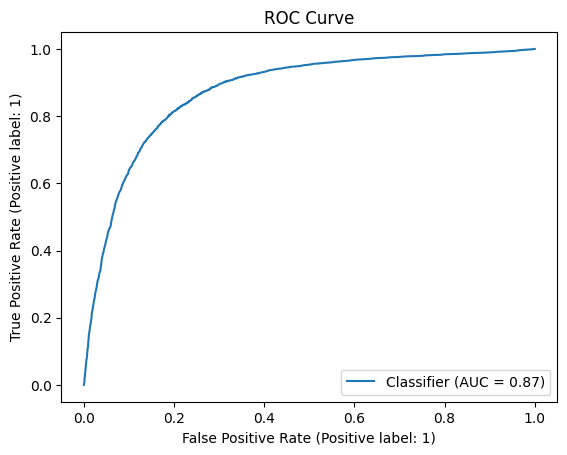

ROC AUC: 0.8750
              precision    recall  f1-score   support

         0.0       0.78      0.79      0.79      7284
         1.0       0.83      0.82      0.83      9010

    accuracy                           0.81     16294
   macro avg       0.81      0.81      0.81     16294
weighted avg       0.81      0.81      0.81     16294



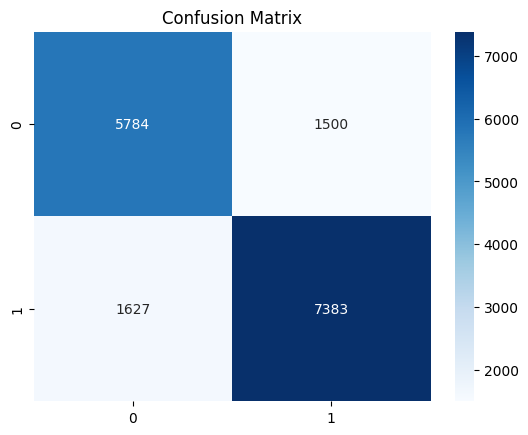

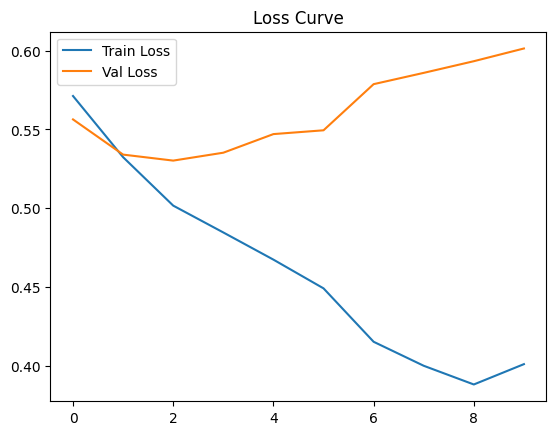

(CFTransformerPlusPlus(
   (text_proj): Linear(in_features=384, out_features=768, bias=True)
   (co_attn): CoAttention(
     (query_img): Linear(in_features=768, out_features=768, bias=True)
     (key_text): Linear(in_features=768, out_features=768, bias=True)
     (value_text): Linear(in_features=768, out_features=768, bias=True)
     (query_text): Linear(in_features=768, out_features=768, bias=True)
     (key_img): Linear(in_features=768, out_features=768, bias=True)
     (value_img): Linear(in_features=768, out_features=768, bias=True)
     (norm_img): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
     (norm_text): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
   )
   (similarity_score): CosineSimilarity()
   (importance_predictor): Sequential(
     (0): Linear(in_features=1537, out_features=256, bias=True)
     (1): GELU(approximate='none')
     (2): Linear(in_features=256, out_features=2, bias=True)
     (3): Softmax(dim=-1)
   )
   (residual_fusion): Linear(in_fea

In [11]:
show_system_status()
model = CFTransformerPlusPlus(img_dim=768, text_dim=384)
train_model(model, train_loader, test_loader)


In [ ]:
'''import torch
import torch.nn as nn
import torch.nn.functional as F

class LateFusionModel(nn.Module):
    def __init__(self, img_dim=768, text_dim=384, hidden_dim=256):
        super().__init__()
        
        # Image branch
        self.img_fc1 = nn.Linear(img_dim, hidden_dim)
        self.img_fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        
        # Text branch
        self.text_fc1 = nn.Linear(text_dim, hidden_dim)
        self.text_fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        
        # Fusion classifier
        self.fusion_fc1 = nn.Linear((hidden_dim // 2) * 2, 128)
        self.dropout = nn.Dropout(0.3)
        self.fusion_fc_out = nn.Linear(128, 1)

    def forward(self, x):
        img = x[:, :768]
        text = x[:, 768:]

        # Image path
        img_out = F.relu(self.img_fc1(img))
        img_out = F.relu(self.img_fc2(img_out))
        
        # Text path
        text_out = F.relu(self.text_fc1(text))
        text_out = F.relu(self.text_fc2(text_out))
        
        # Late fusion
        combined = torch.cat([img_out, text_out], dim=-1)
        x = F.relu(self.fusion_fc1(combined))
        x = self.dropout(x)
        out = self.fusion_fc_out(x)
        return out
'''

In [ ]:
'''import torch
import torch.nn as nn
import torch.nn.functional as F

class HierarchicalFusionModel(nn.Module):
    def __init__(self, img_dim=768, text_dim=384, hidden_dim=512):
        super().__init__()

        # Stage 1: Project image & text independently
        self.img_proj1 = nn.Linear(img_dim, hidden_dim)
        self.text_proj1 = nn.Linear(text_dim, hidden_dim)

        # Stage 1 Fusion
        self.fusion1 = nn.Linear(hidden_dim * 2, hidden_dim)

        # Stage 2: Intermediate transformation
        self.img_proj2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.text_proj2 = nn.Linear(hidden_dim, hidden_dim // 2)

        # Stage 2 Fusion
        self.fusion2 = nn.Linear((hidden_dim // 2) * 2, hidden_dim)

        # Final Classification
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        img = x[:, :768]
        text = x[:, 768:]

        # Stage 1 Projections
        img_stage1 = F.relu(self.img_proj1(img))
        text_stage1 = F.relu(self.text_proj1(text))

        # Stage 1 Fusion
        fusion1 = torch.cat([img_stage1, text_stage1], dim=-1)
        fusion1 = F.relu(self.fusion1(fusion1))

        # Stage 2 Projections
        img_stage2 = F.relu(self.img_proj2(img_stage1))
        text_stage2 = F.relu(self.text_proj2(text_stage1))

        # Stage 2 Fusion
        fusion2 = torch.cat([img_stage2, text_stage2], dim=-1)
        fusion2 = F.relu(self.fusion2(fusion2))

        # Final Output
        fused = fusion1 + fusion2  # Residual connection
        fused = self.dropout(fused)
        out = self.classifier(fused)
        return out
'''

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CrossModalAttention(nn.Module):
    def __init__(self, img_dim=768, text_dim=384, hidden_dim=512, num_heads=4):
        super().__init__()
        self.img_q = nn.Linear(img_dim, hidden_dim)
        self.text_k = nn.Linear(text_dim, hidden_dim)
        self.text_v = nn.Linear(text_dim, hidden_dim)
        
        self.text_q = nn.Linear(text_dim, hidden_dim)
        self.img_k = nn.Linear(img_dim, hidden_dim)
        self.img_v = nn.Linear(img_dim, hidden_dim)

        self.attn_img_to_text = nn.MultiheadAttention(hidden_dim, num_heads, batch_first=True)
        self.attn_text_to_img = nn.MultiheadAttention(hidden_dim, num_heads, batch_first=True)

        self.residual_img = nn.Linear(img_dim, hidden_dim)
        self.residual_text = nn.Linear(text_dim, hidden_dim)

    def forward(self, img, text):
        # Expand dimensions to batch x seq_len x dim (seq_len=1)
        img = img.unsqueeze(1)
        text = text.unsqueeze(1)

        # Project queries, keys, values
        q_img = self.img_q(img)
        k_text = self.text_k(text)
        v_text = self.text_v(text)

        q_text = self.text_q(text)
        k_img = self.img_k(img)
        v_img = self.img_v(img)

        # Attention: image attends to text
        img_attn, _ = self.attn_img_to_text(q_img, k_text, v_text)
        img_attn = img_attn + self.residual_img(img)  # Residual connection

        # Attention: text attends to image
        text_attn, _ = self.attn_text_to_img(q_text, k_img, v_img)
        text_attn = text_attn + self.residual_text(text)  # Residual connection

        # Remove sequence dimension
        return img_attn.squeeze(1), text_attn.squeeze(1)


In [ ]:
'''class CrossModalResidualClassifier(nn.Module):
    def __init__(self, img_dim=768, text_dim=384, hidden_dim=512):
        super().__init__()
        self.attn = CrossModalAttention(img_dim, text_dim, hidden_dim)

        self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.out = nn.Linear(hidden_dim // 2, 1)
        self.dropout = nn.Dropout(0.3)

        self.res1 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.res2 = nn.Linear(hidden_dim * 2, hidden_dim // 2)

    def forward(self, x):
        img, text = x[:, :768], x[:, 768:]
        img_out, text_out = self.attn(img, text)

        fused = torch.cat([img_out, text_out], dim=-1)
        r1 = self.res1(fused)
        x = F.relu(self.fc1(fused)) + r1
        x = self.dropout(x)

        r2 = self.res2(fused)
        x = F.relu(self.fc2(x)) + r2
        x = self.dropout(x)

        return self.out(x)
'''